# Step 2. Visualization
In this notebook, we use the data organized in the `clean-data` notebook to make visualziations.

In [32]:
# Time for timestamps on plotly models
import time

# Numpy and pandas for manipulating the data
import numpy as np
import pandas as pd

# Scipy stats for statistical tests
import scipy.stats

# Matplotlib and seaborn for visualization
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns

# Plotly for maps
import plotly
import plotly.plotly as py
import plotly.figure_factory as ff
from plotly.grid_objs import Grid, Column
from plotly import tools

# statsmodel for seasonal decomposition  
from statsmodels.tsa.seasonal import seasonal_decompose

# minmax scaler to standardize variables for plotting
from sklearn.preprocessing import MinMaxScaler

In [33]:
# First let's read in our clean data
provisions_file = './data/raw/provisions.csv' # We'll need this
lat_long_file = './data/cleaned/lat_long.csv'
by_date_total_file = './data/cleaned/by_date_total.csv'
annual_file = './data/cleaned/annual_gun.csv'

provisions_df = pd.read_csv(provisions_file, parse_dates=True)
lat_long_df = pd.read_csv(lat_long_file, parse_dates=True, index_col=0)
by_date_total_df = pd.read_csv(by_date_total_file, parse_dates=True, index_col=0)
annual_df = pd.read_csv(annual_file, parse_dates=True, index_col=0)

In [34]:
# Styling
# make figures bigger
mpl.rcParams['figure.figsize'] = 15, 8

# change grid line styling
mpl.rcParams['grid.color'] = '#d6dbdf'
mpl.rcParams['grid.linestyle'] = '-'
mpl.rcParams['grid.linewidth'] = 0.5

# make markers smaller
mpl.rcParams['lines.markersize'] = 4
mpl.rcParams['axes.edgecolor'] = '#d6dbdf'
mpl.rcParams['xtick.color'] = '#d6dbdf'
mpl.rcParams['ytick.color'] = '#d6dbdf'

# change font
mpl.rcParams['font.family'] = 'Open Sans'

mpl.rcParams['axes.prop_cycle'] = plt.cycler(color=['#6377cb', '#cb63ab'])

# define colors for republican and democrat
rep_color='#e74c3c'
dem_color='#3498db'

# Function to apply styling that can't be set default with mpl.rcParams
def apply_styling(grid=True):
    plt.xticks(color='k')
    plt.yticks(color='k')
    if grid:
        plt.grid()

In [35]:
## # Exclude District of Columbia from some of our visualizations because it's extreme outlier
# annual_df = annual_df[annual_df['state'] != 'District of Columbia']

# Get a random subset of n states to plot (too many states) 
def get_random_states(n=12, seed=1):
    # referencing annual_df from outside function
    return list(annual_df.groupby('state').count().sample(n, random_state=seed).index)

# Function to plot feature trends easily
def plot_feature_trends(column1, label1=None, column2='gun_deaths_norm', label2=None,
                        title=None, rows=4, cols=3, seed=1, colors=['#6377cb', '#cb63ab']):
    """Sample random states and plot featuresagainst eaceh other.
    
    column1  (str): Name of the column from annual_df to plot column2 trends 
    against. Both features specified will be min-maxed to share a y axis.
    
    label1   (str): label that will appear in the legend as the name of the
    first feature. If unspecified, defaults to column1.
    
    column2  (str): Name of the 2nd column to plot trends against. Defaults 
    to 'gun_deaths_norm'.
    
    label2   (str): label that will appear in the legend as the name of the
    second feature. If unspecified, defaults to column2.
    
    title    (str): Title of the plot. If unspecified, title will be generated.
    
    row      (int): Number of rows in the subplot grid.
    
    col      (int): Number of columns in the subplot grid.
    
    seed     (int): Random state used to sample the states with.
    
    colors  (list): Colors to use (length 2).
    """
    
    if label1 is None:
        label1 = column1
        
    if label2 is None:
        if column2 == 'gun_deaths_norm':
            label2 = 'Gun Homicide'
        else:
            label2 = column2
    
    # Get n random states to fill the subplot
    n = rows * cols
    states = get_random_states(n, seed)
    
    # referencing annual_df from outside the function; get relevant columns
    temp_df = annual_df[['state', 'year', column1, column2]]
    temp_df = temp_df.dropna()
    
    # Make the figure bigger
    plt.figure(figsize=(15, 12))
    
    # For each state...
    for i, state in enumerate(states):
        plt.subplot(rows, cols, i + 1)
        get_state = temp_df['state'] == state

        # Get the first column and min-max
        first = temp_df.loc[get_state, ['year', column1]]
        first = first.set_index('year').dropna()
        first_scaler = MinMaxScaler()
        first[column1] = first_scaler.fit_transform(first)

        # Get the second column and min-max
        second = temp_df.loc[get_state, ['year', column2]]
        second = second.set_index('year').dropna()
        second_scaler = MinMaxScaler()
        second[column2] = second_scaler.fit_transform(second)

        # Plot the two trends on the same set of axes
        plt.plot(first, label=label1, color=colors[0])
        plt.plot(second, label=label2, color=colors[1])
        plt.title(state)
        apply_styling()
        
        # Only make a legend on the first plot
        if i == 0:
            plt.legend() 
            
    # Create a title if there is none:
    if title is None:
        title = "{} and {} Trends ({}-{})".format(label1,
                                                label2,
                                                first.index.min(),
                                                first.index.max())
    plt.suptitle(title, fontsize=18)
    plt.subplots_adjust(top=0.92, hspace=0.4) # Space out the plots a bit more vertically
    plt.show()

***
## Trend Visualization

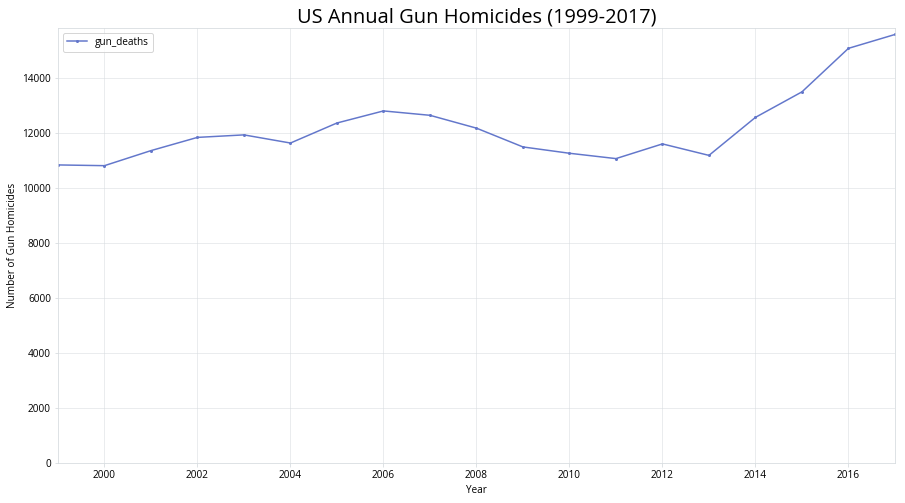

In [36]:
# For our first visualizations, let's just plot the gun homicide trend in two ways:

# Annual from 1999-2017
country_annual_df = annual_df[['state', 'year', 'gun_deaths']].groupby('year').sum()
country_annual_df.plot(marker='.')
plt.title('US Annual Gun Homicides (1999-2017)', size=20)
plt.xlabel('Year')
plt.ylabel('Number of Gun Homicides')
apply_styling()
plt.ylim(0)
# [plt.annotate(int(y), xy=(x, y), textcoords='data') 
#    for x, y in zip(country_annual_df.index, country_annual_df['gun_deaths'])]
plt.show()

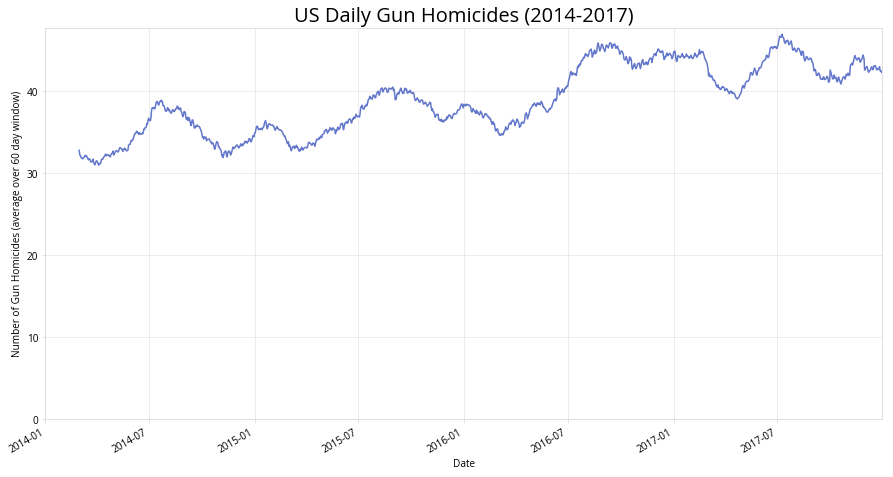

In [37]:
# Daily mean with window from 2014-2017
win_size = 60

country_gun_df = by_date_total_df['2014':'2017'].sum(axis=1)
country_gun_df.rolling(window=win_size).mean().plot()
plt.title('US Daily Gun Homicides (2014-2017)', size=20)
plt.xlabel('Date')
plt.ylabel('Number of Gun Homicides (average over {} day window)'.format(win_size))
plt.ylim(0)
apply_styling()
plt.show()

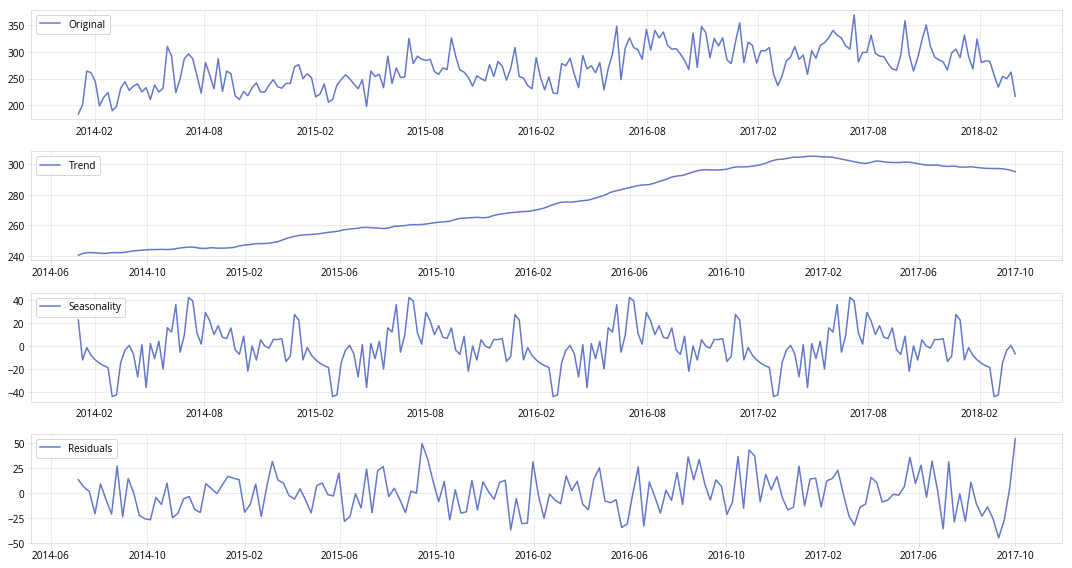

In [38]:
# It looks like there's some seasonality, and an upward trend, but let's take a closer look:

# Plot and the decomposition of the time series and into trend, seasonal, and residual noise.
time_series = by_date_total_df.resample('W').sum().sum(axis=1)
decomposition = seasonal_decompose(time_series)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid


plt.subplot(4,1,1)
plt.plot(time_series, label='Original')
plt.legend(loc='upper left')
apply_styling()

plt.subplot(4,1,2)
plt.plot(trend, label='Trend')
plt.legend(loc='upper left')
apply_styling()

plt.subplot(4,1,3)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='upper left')
apply_styling()

plt.subplot(4,1,4)
plt.plot(residual, label='Residuals')
plt.legend(loc='upper left')
apply_styling()

plt.tight_layout()
plt.show()

From the decomposition, there seems to be a general **increasing** trend, and some seasonalty that suggests **spikes in gun violence during the summer** and at the **beginning of each new year**.

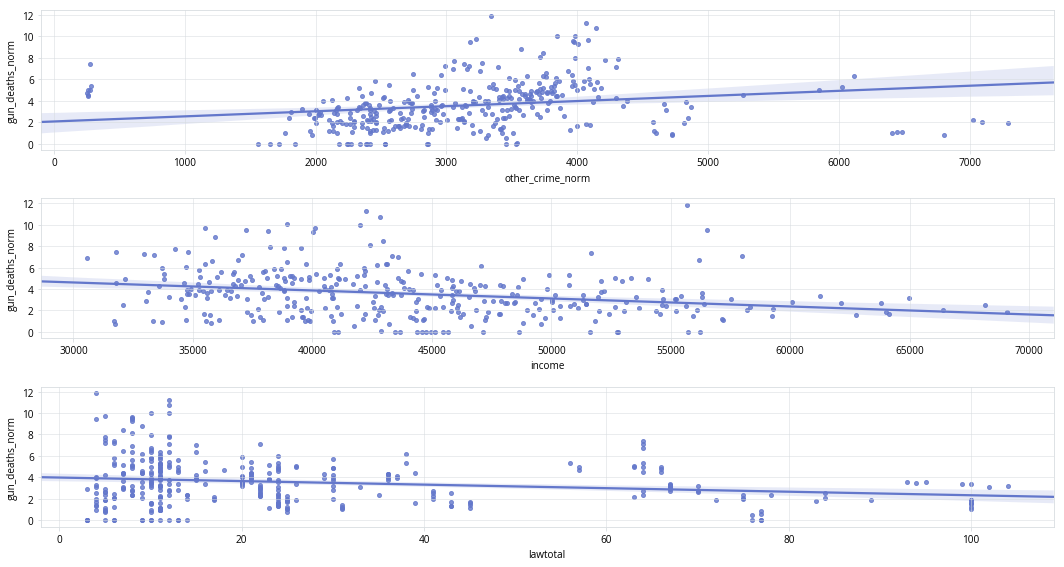

In [39]:
# Plot these features against gun homicide rates
to_plot = ['other_crime_norm', 'income', 'lawtotal']
n_items = len(to_plot)

temp_df = annual_df[to_plot + ['gun_deaths_norm']].dropna()

for i, column in enumerate(to_plot):
    plt.subplot(n_items, 1, i + 1)
    sns.regplot(temp_df[column], temp_df['gun_deaths_norm'])
    apply_styling()

plt.subplot(n_items, 1, 1)
plt.tight_layout()
plt.show()

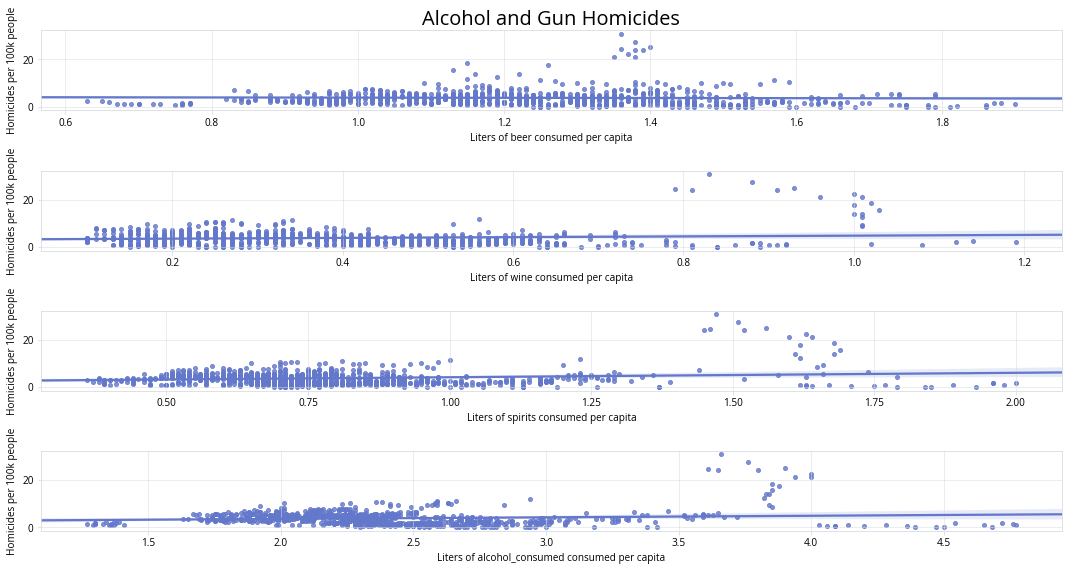

In [41]:
# Plot gun deaths as they relate to alcohol consumption
to_plot = ['beer', 'wine', 'spirits', 'alcohol_consumed']
n_items = len(to_plot)

temp_df = annual_df[to_plot + ['gun_deaths_norm']].dropna()

for i, column in enumerate(to_plot):
    plt.subplot(n_items, 1, i + 1)
    sns.regplot(temp_df[column], temp_df['gun_deaths_norm'])
    plt.ylabel('Homicides per 100k people')
    plt.xlabel('Liters of {} consumed per capita'.format(column))
    apply_styling()

plt.subplot(n_items, 1, 1)
plt.title('Alcohol and Gun Homicides', size=20)
plt.tight_layout()
plt.show()

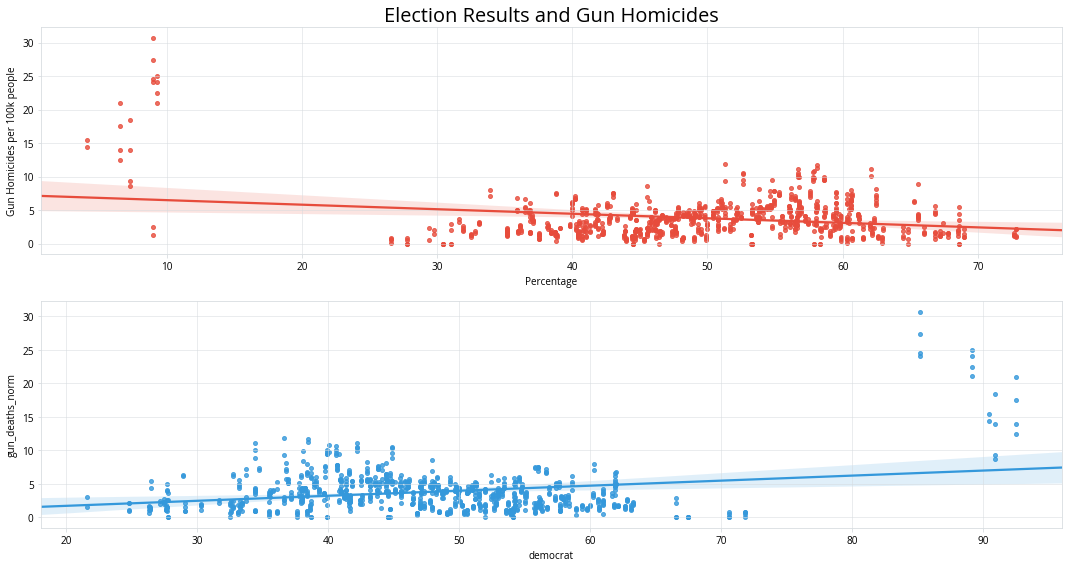

In [42]:
# Plot gun violence as it relates to election results
# Republican
plt.subplot(2, 1, 1)
sns.regplot(annual_df['republican'], annual_df['gun_deaths_norm'], color='#e74c3c')
plt.xlabel("Percentage")
plt.ylabel("Gun Homicides per 100k people")
apply_styling()

# Democrat
plt.subplot(2, 1, 2)
sns.regplot(annual_df['democrat'], annual_df['gun_deaths_norm'], color='#3498db')
apply_styling()

plt.subplot(2, 1, 1)
plt.title('Election Results and Gun Homicides', size=20)
plt.tight_layout()
plt.show()

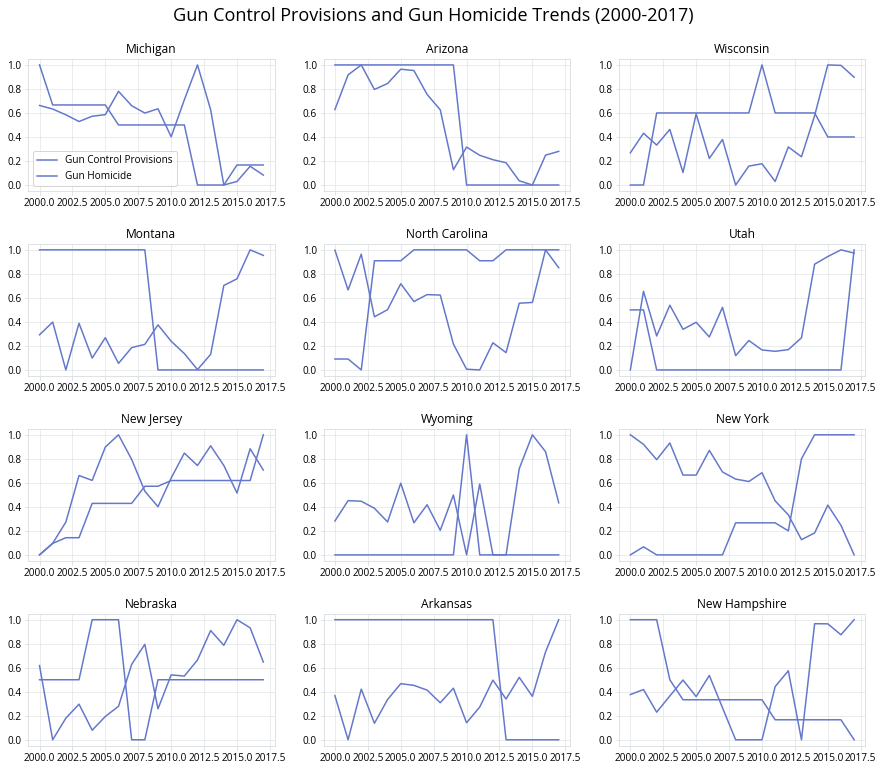

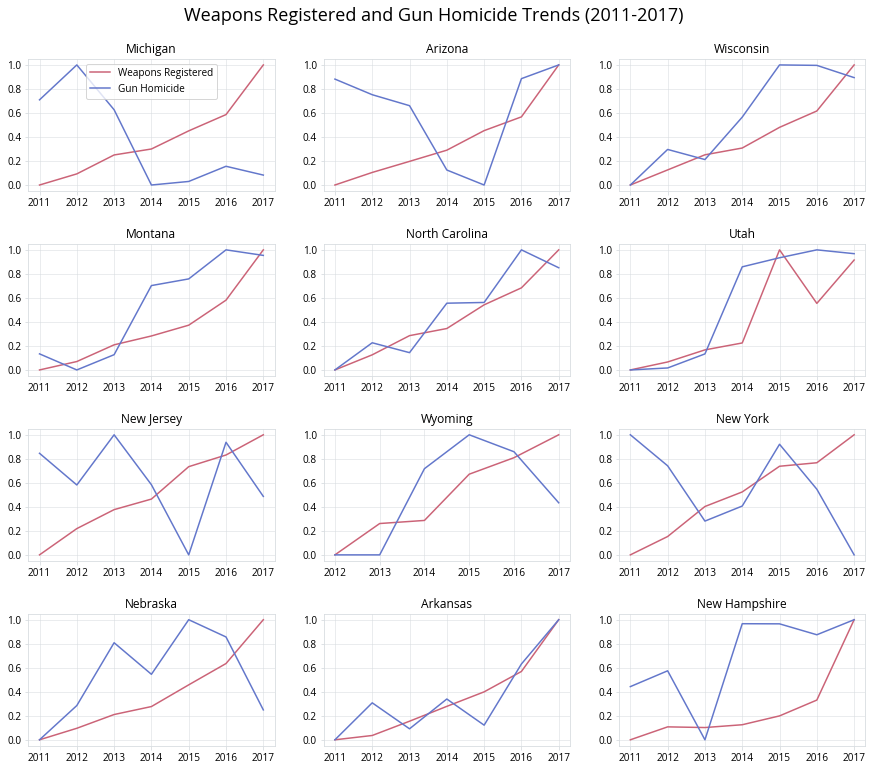

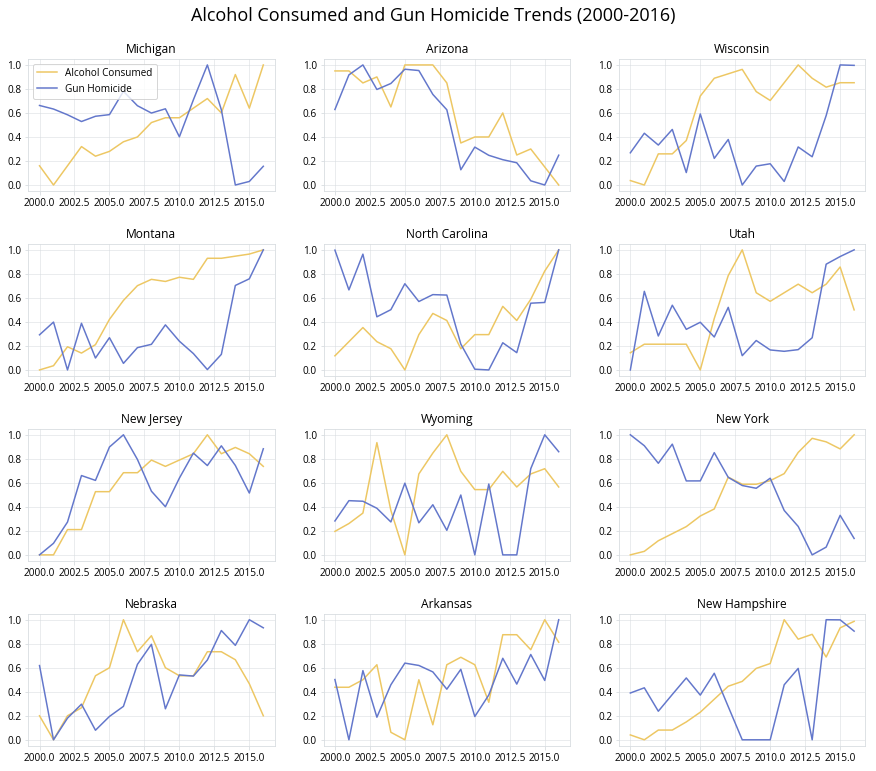

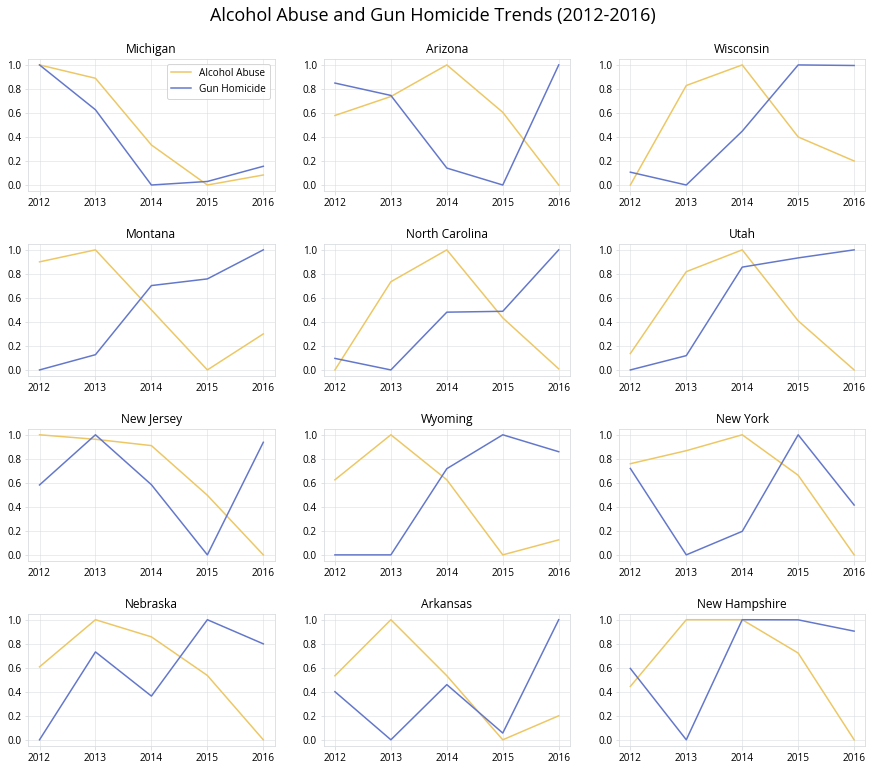

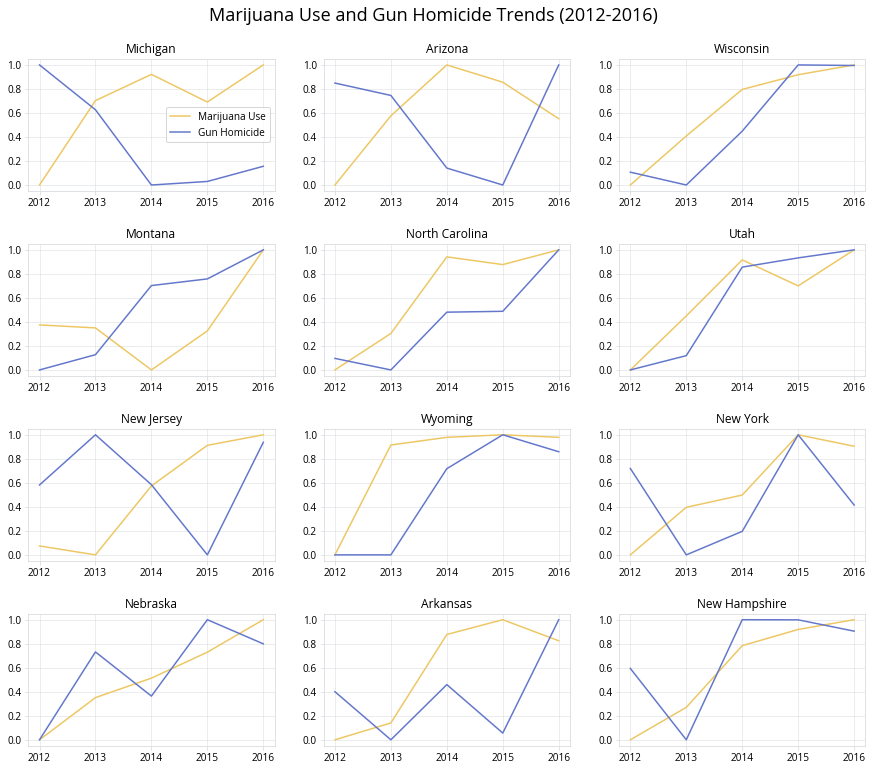

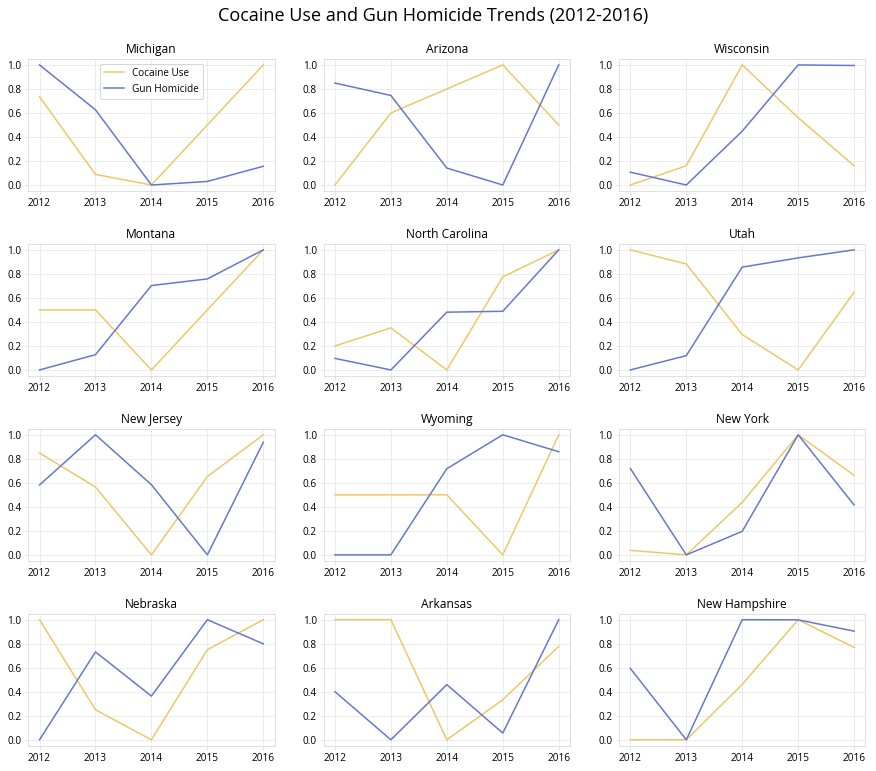

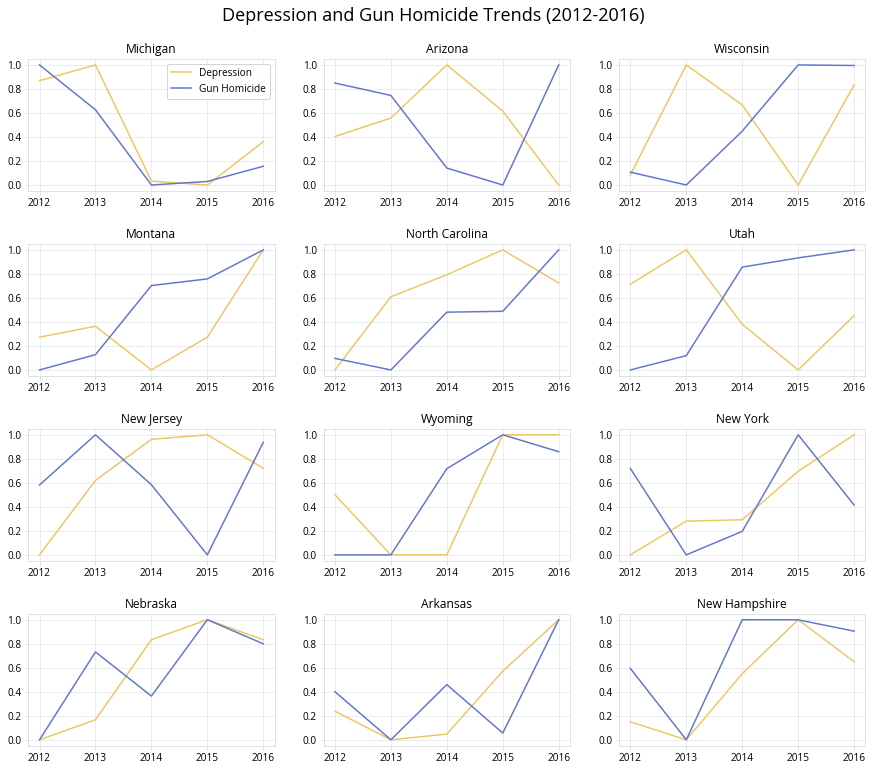

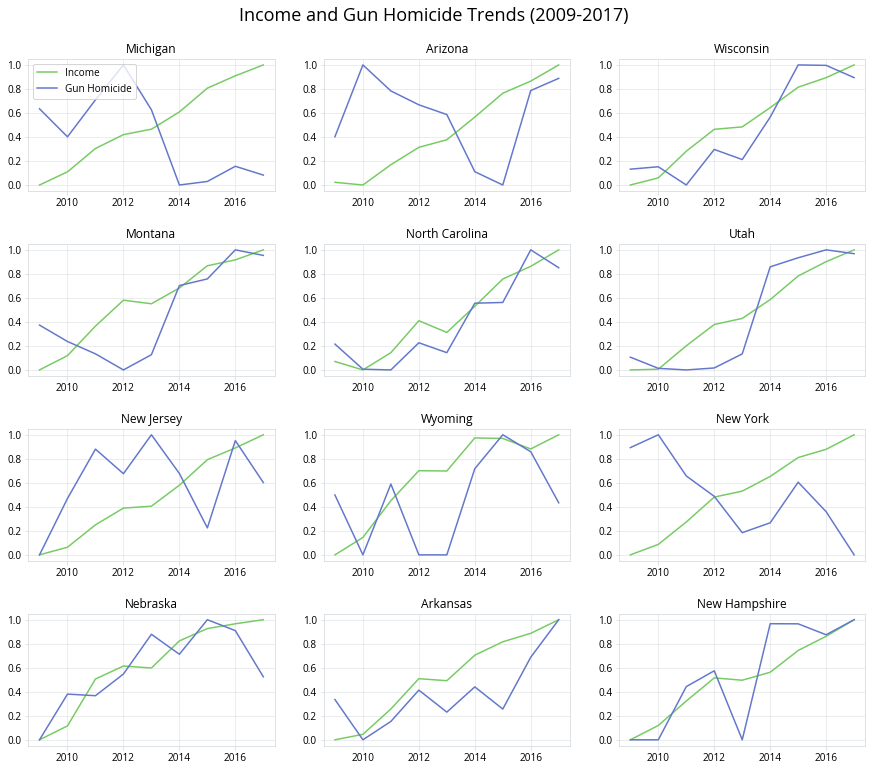

In [45]:
# Visualize total gun control provisions
plot_feature_trends('lawtotal', 'Gun Control Provisions', colors=['#6377cb', '#6377cb'])

# Visualize total weapons registrations
plot_feature_trends('total_weapons', 'Weapons Registered', colors=['#cb6377', '#6377cb'])

# Visualize all alcohol consumed 
plot_feature_trends('alcohol_consumed', 'Alcohol Consumed', colors=['#edc763', '#6377cb'])

# Visualize alcohol abuse
plot_feature_trends('alcohol_abuse', 'Alcohol Abuse', colors=['#edc763', '#6377cb'])

# Visualize marijuana use
plot_feature_trends('marijuana', 'Marijuana Use', colors=['#edc763', '#6377cb'])

# Visualize cocaine use
plot_feature_trends('cocaine', 'Cocaine Use', colors=['#edc763', '#6377cb'])

# Visualize depression effects
plot_feature_trends('depression', 'Depression', colors=['#edc763', '#6377cb'])

# Visualize income trends
plot_feature_trends('income', 'Income', colors=['#77cb63', '#6377cb'])

It's hard to make any assumptions about the effects of gun control provisions just by looking at these charts, so let's look a bit closer by examining the effects of each provision individually:

In [12]:
# Function to compare the effects of provisions on gun violence
def compare_provisions(annual_df, provisions_df, threshold=15, year=2017):
    """Return a DataFrame with differences in gun homicides w.r.t. provisions 
    
    threshold   (int): the minimum number of states that have the provision for it 
    to be included in the results. This prevents misleading results (e.g. from 
    laws that only Hawaii has) and helps to control for sample size difference.

    year        (int): the year which we should conduct our comparisons in. We 
    focus on one year because we used an independent t-test and observations 
    from the same state across different years are not independent, whereas 
    assuming independence of observations from different states is not as assuming.   
    """

    # Create a dataframe with 2017 entires 
    provisions = provisions_df.columns[2:-1]
    filtered_df = pd.merge(annual_df, provisions_df)
    filtered_df = filtered_df[filtered_df['year'] == year]

    # Remove where provisions sum less than threshold
    provisions = provisions[filtered_df[provisions].sum() > threshold]

    # Lists to remember gun homicides p_values for states w/ and w/o each law 
    a_list, b_list, p_list, a_size_list = [], [], [], []

    # Find differences between states w/wo each law
    for p in provisions:
        ab = filtered_df.groupby(p)['gun_deaths_norm'].mean()
        # Append the a and b means to a_list and b_list
        a_list.append(ab[0])
        b_list.append(ab[1])

        # Get a p value using the Welch's t-test; **assumptions of t-test
        without_law = filtered_df[filtered_df[p] == 0]['gun_deaths_norm']
        with_law = filtered_df[filtered_df[p] == 1]['gun_deaths_norm']
        p_list.append(scipy.stats.ttest_ind(without_law, with_law).pvalue)

        a_size_list.append(filtered_df[filtered_df[p] == 0].shape[0])

    # Organize our results in a dataframe to make it easy to read
    results_df = pd.DataFrame()
    results_df['provision'] = provisions
    results_df['without'] = a_list
    results_df['with'] = b_list
    results_df['diff'] = results_df['without'] - results_df['with'] 
    results_df['p_value'] = p_list
    results_df['n_without'] = a_size_list
    results_df = results_df.sort_values('diff', ascending=False)

    return results_df

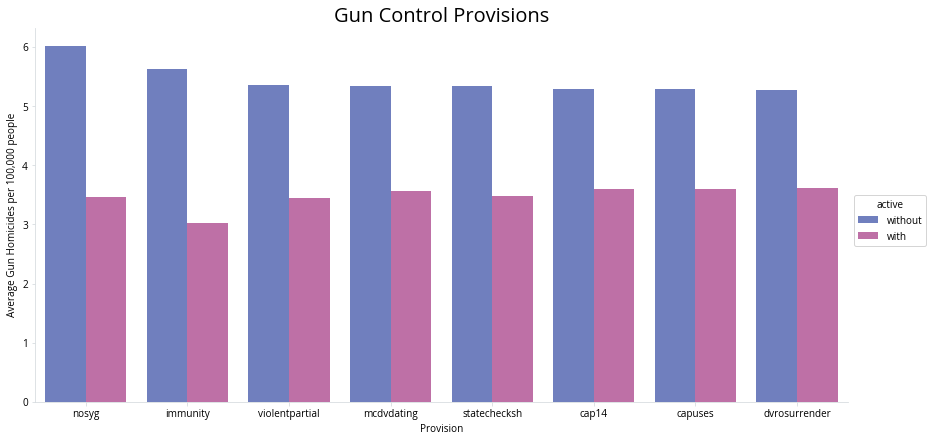

In [13]:
# Look each provision and see if there are any provisions that make a bigger effect
# Get comparisons between gun homicide rates with and without the provisions
results = compare_provisions(annual_df, provisions_df, 15, 2017)

# Plot the results in a subplot grid
head_size = 8

# Get some of the results to plot and reformat so w/ and w/o columns are in rows instead
results_head = results.head(head_size).set_index('provision')
results_head = results_head[['with', 'without']].stack().reset_index()
results_head.columns = ['provision', 'active', 'gun_deaths_norm']
results_head = results_head.sort_values('gun_deaths_norm', ascending=False) 

# Plot the with and without side-by-side in a bar graph
facet_grid = sns.factorplot(x='provision', y='gun_deaths_norm',
                hue='active', data=results_head, 
                kind='bar', size=6, aspect=2.0)
plt.title('Gun Control Provisions', size=20)
plt.xlabel('Provision')
plt.ylabel('Average Gun Homicides per 100,000 people')
apply_styling(grid=False)
plt.show()

# Save provisions that may be significantly more useful
useful_provisions = compare_provisions(annual_df, provisions_df, 10, 2017)
useful_provisions = useful_provisions.sort_values('p_value').head(30)
useful_provisions.to_csv('./data/cleaned/useful_provisions.csv')

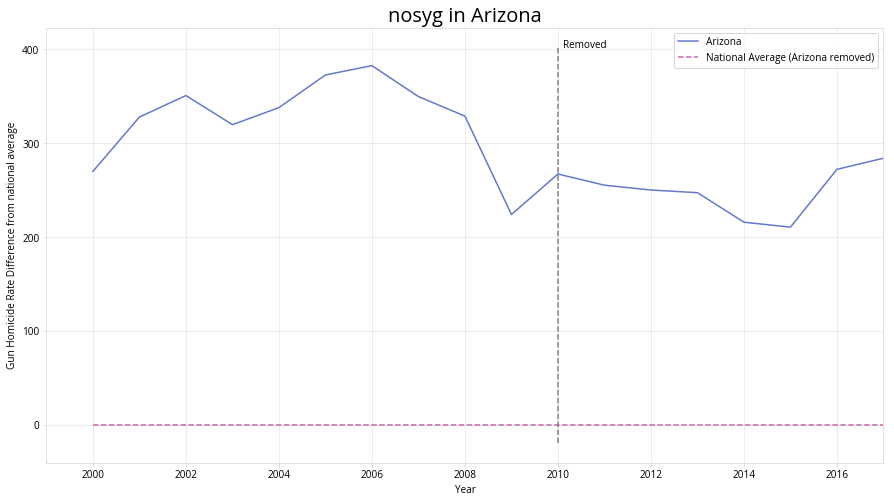

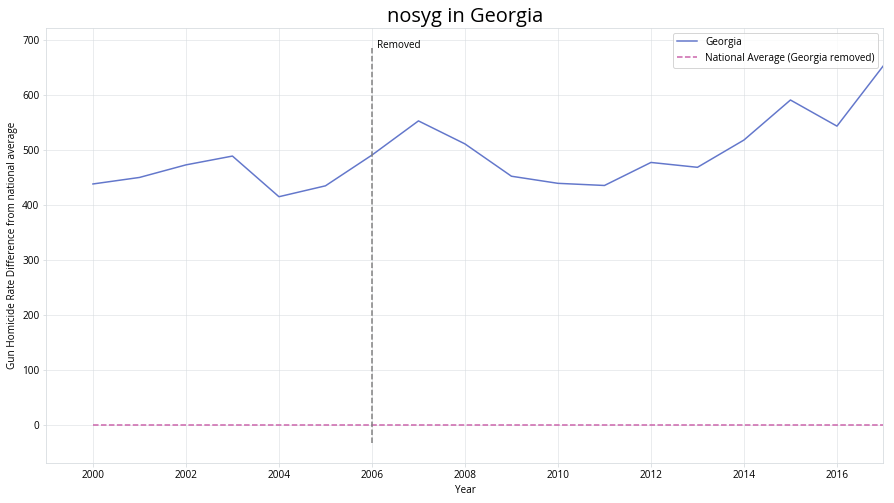

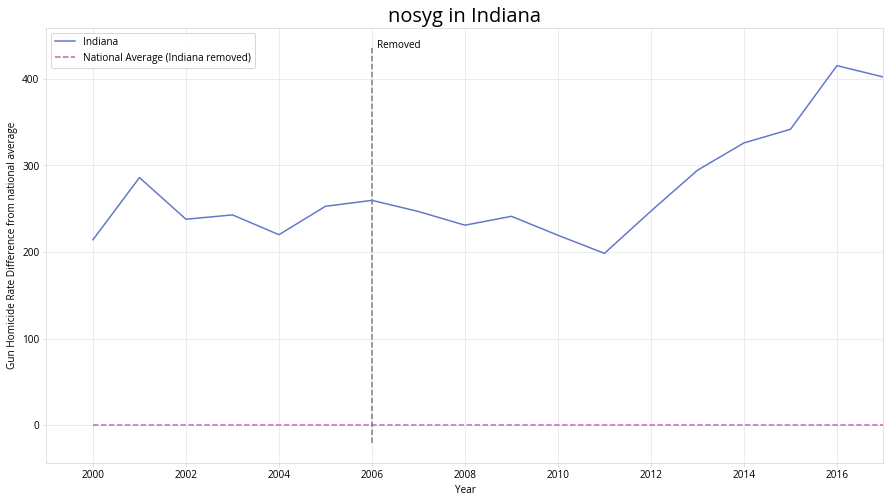

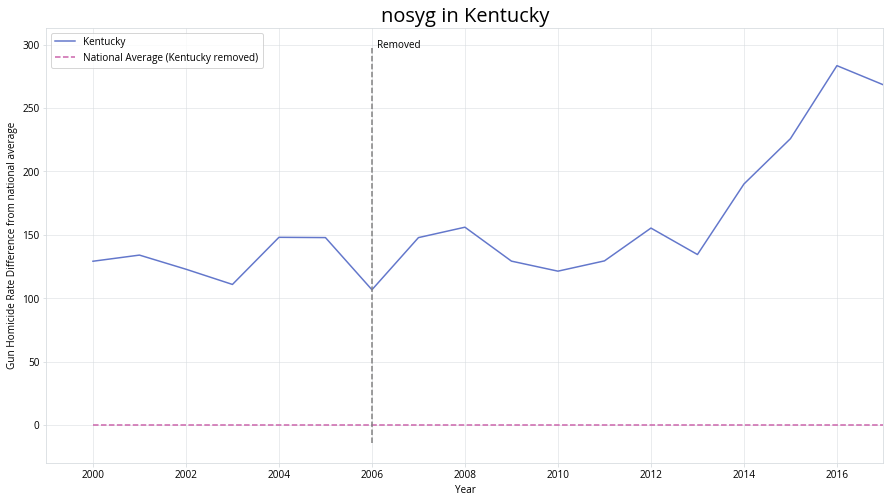

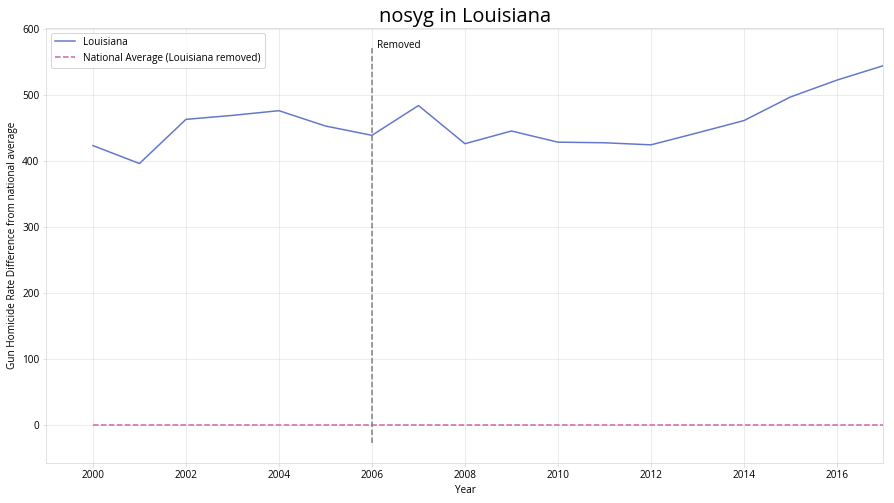

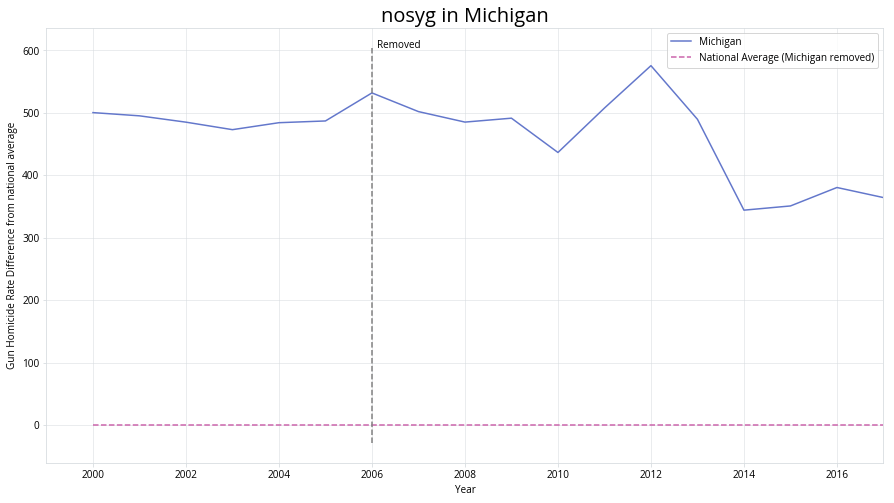

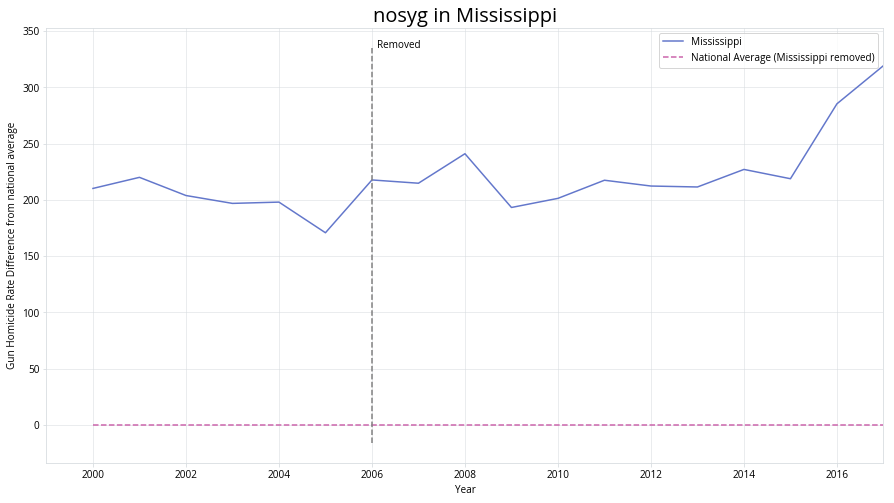

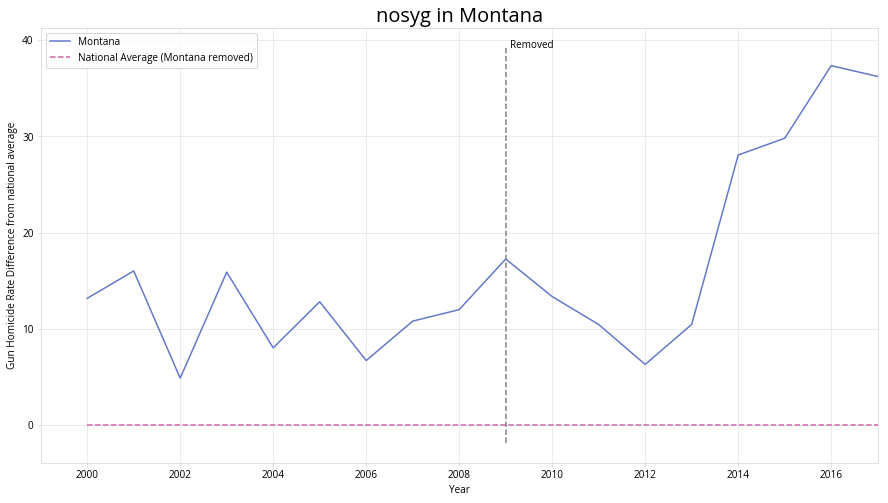

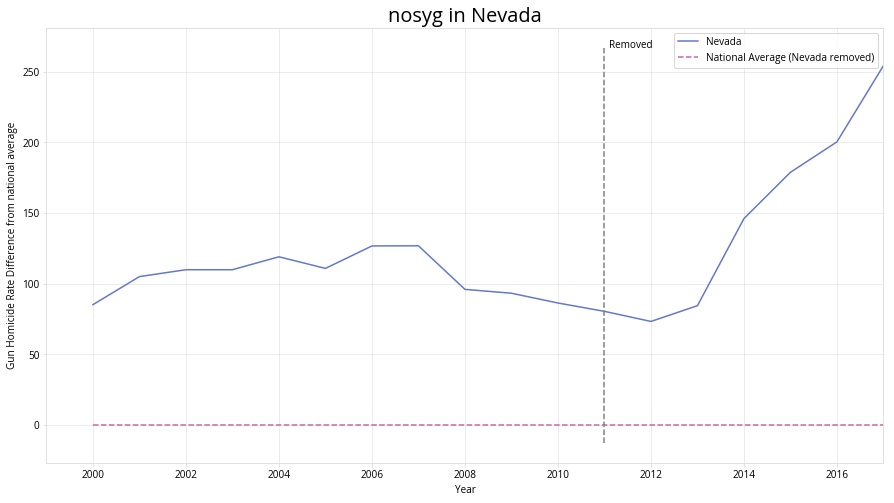

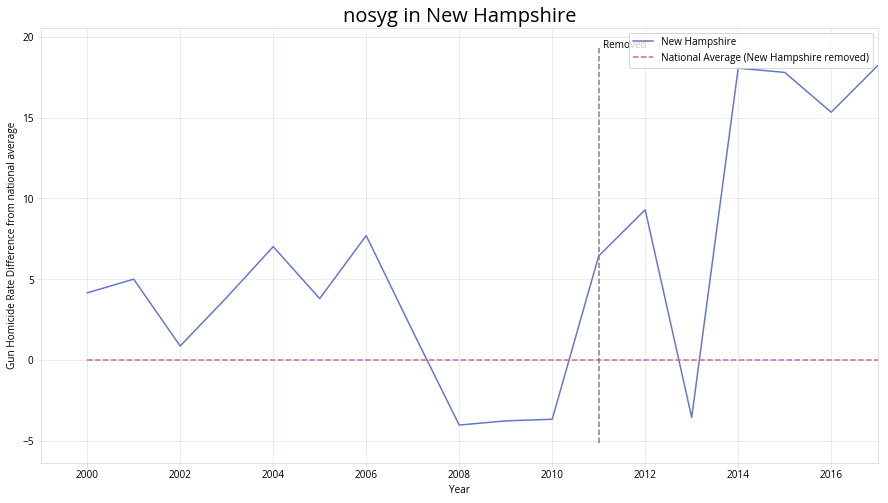

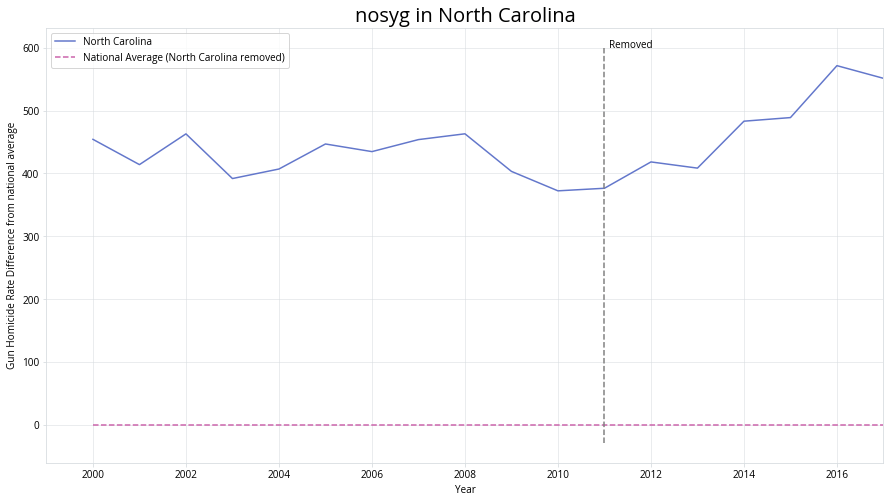

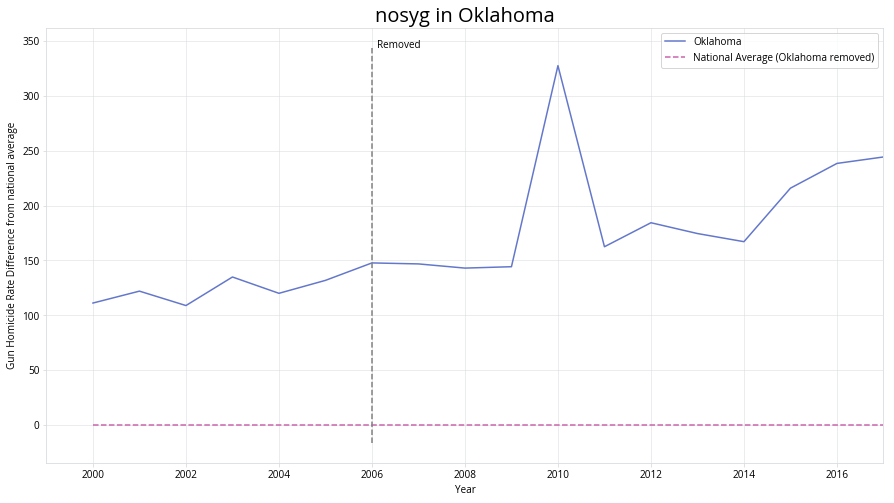

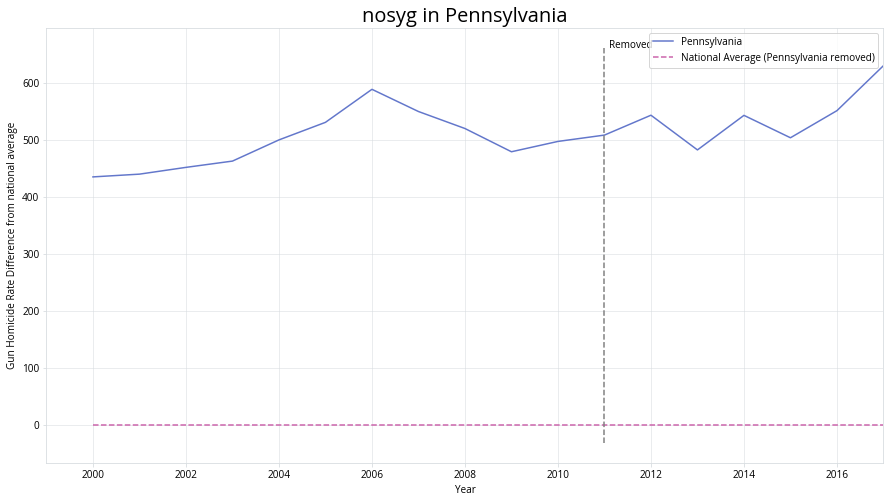

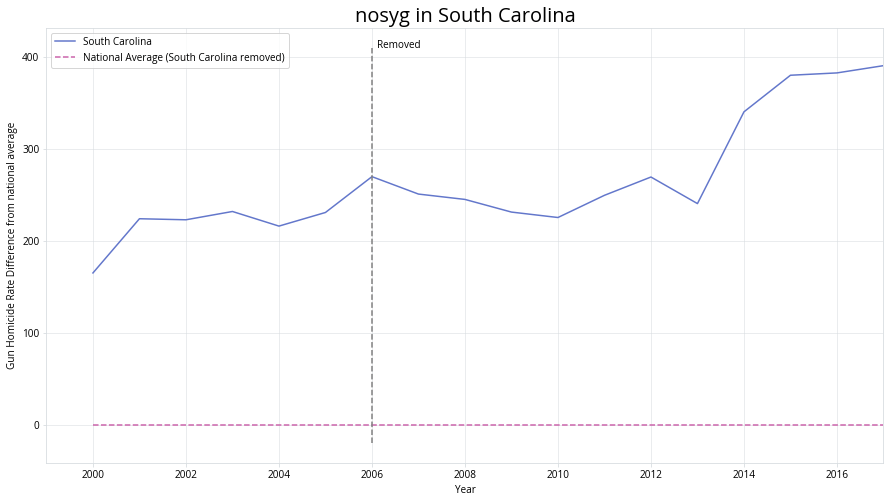

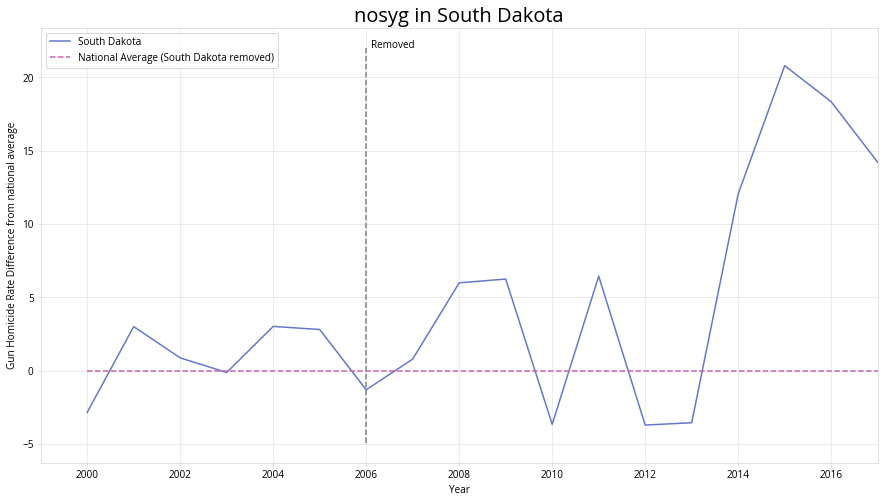

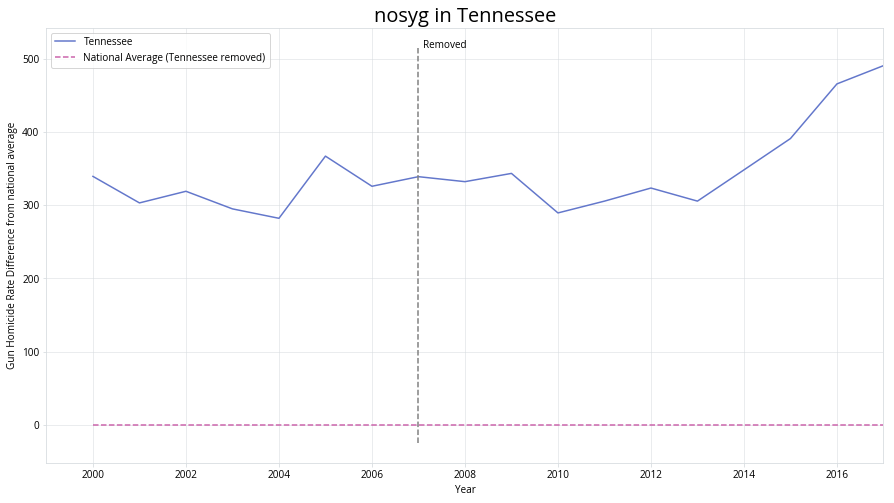

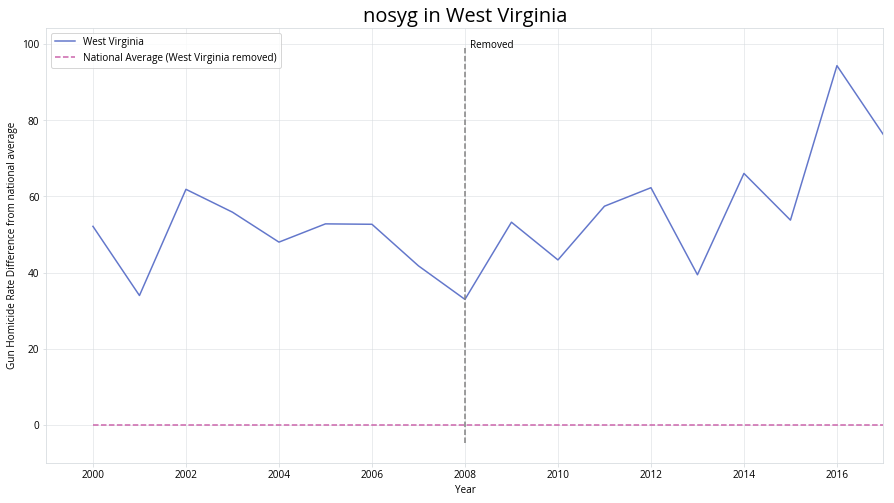

In [14]:
# Let's examine some of these more carefully

# Get where law changes
def get_law_changes(filtered_provisions, state):
    changes = filtered_provisions[state] - filtered_provisions[state].shift()
    changes = changes.dropna()
    changes = changes[changes != 0]
    return changes.apply(lambda x: 'Added' if x > 0 else 'Removed')

# Plot provision
def visualize_provision(provision, lower_thresh=1, upper_thresh=16):
    # Limit to one provision
    one_provision_df = provisions_df[['state', 'year', provision]]

    # Get states within threshold 
    states_df = one_provision_df.groupby('state')[provision].sum()
    apply_threshold = (states_df > lower_thresh) & (states_df < upper_thresh)
    states_df = states_df[apply_threshold]

    # Filter from the one_provision_df
    filtered_provisions = one_provision_df.set_index('state').loc[states_df.index]
    filtered_provisions = filtered_provisions.pivot_table(index='year', 
                                                          columns='state', 
                                                          values=provision)

    # Plot each state's gun homicide rate and the national average
    for state in filtered_provisions.columns:
        # Get bounds for law changes
        law_changes = get_law_changes(filtered_provisions, state)

        # Get entries excluding the state of interest
        exclude_state = annual_df[annual_df['state'] != state]
        # Calculate national total and average from those entries
        national_total = exclude_state.groupby('year')['gun_deaths'].sum(axis=1)
        national_avg = national_total / exclude_state.groupby('year')['population'].sum()
        national_avg = national_avg * 100000
        # Take difference of trends from the state and the national average and plot it
        annual_by_date_df = annual_df.pivot_table(index='year', 
                                                  columns='state', 
                                                  values='gun_deaths')        
        difference = annual_by_date_df[state] - national_avg
        difference.plot(label=state)

        # Plot the national average        
        plt.plot([2000, 2017], [0, 0], ls='--', label='National Average ({} removed)'.format(state))

        y_bounds = plt.ylim()
        # And for each time the law changes, we plot a dotted line to indicate
        for year in law_changes.index:
            plt.plot([year, year], y_bounds, ls='--', color='grey')
            plt.annotate(law_changes[year], xy=(year + 0.1, y_bounds[1]), textcoords='data', color='k')

        plt.title('{} in {}'.format(provision, state), size=20)
        plt.xlabel('Year')
        plt.ylabel('Gun Homicide Rate Difference from national average')

        apply_styling()
        plt.legend(loc='best')
        plt.show()
        
# Remove dates before 2000 from provisions_df
provisions_df['year'] = provisions_df['year'].astype(int)
provisions_df = provisions_df[provisions_df['year'] >= 2000]
big_state_filter = provisions_df['state'].isin(get_random_states(40))
provisions_df = provisions_df[big_state_filter]

# We can visualize other provisions, but there are SO MANY CHARTS 
# so... we'll just do the one with the biggest difference
visualize_provision('nosyg')

Now, let's have some fun and look at an interactive map! 

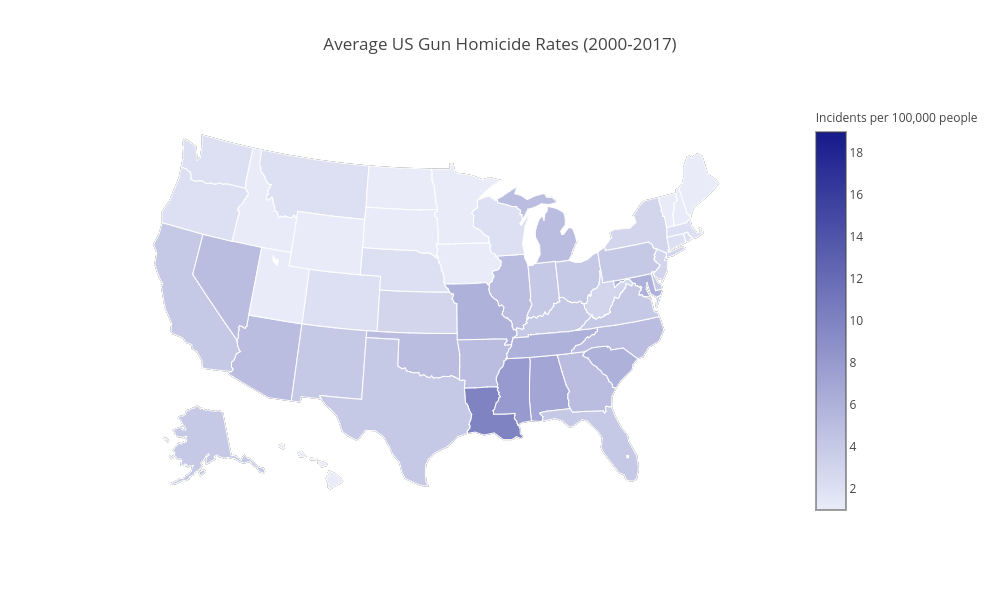

In [15]:
# Map out the normalized crime
# Dictionary to turn state names into abbreviations
states_codes = {
    'Alaska': 'AK', 'Alabama': 'AL', 'Arkansas': 'AR', 'Arizona': 'AZ', 'California': 'CA', 
    'Colorado': 'CO', 'Connecticut': 'CT', 'District of Columbia': 'DC', 'Delaware': 'DE', 
    'Florida': 'FL', 'Georgia': 'GA', 'Hawaii': 'HI', 'Iowa': 'IA', 'Idaho': 'ID', 
    'Illinois': 'IL', 'Indiana': 'IN', 'Kansas': 'KS', 'Kentucky': 'KY', 'Louisiana': 'LA', 
    'Massachusetts': 'MA', 'Maryland': 'MD', 'Maine': 'ME', 'Michigan': 'MI', 
    'Minnesota': 'MN', 'Missouri': 'MO', 'Northern Mariana Islands': 'MP', 'Mississippi': 'MS', 
    'Montana': 'MT', 'North Carolina': 'NC', 'North Dakota': 'ND', 'Nebraska': 'NE', 
    'New Hampshire': 'NH', 'New Jersey': 'NJ', 'New Mexico': 'NM', 'Nevada': 'NV', 
    'New York': 'NY', 'Ohio': 'OH', 'Oklahoma': 'OK', 'Oregon': 'OR', 'Pennsylvania': 'PA', 
    'Rhode Island': 'RI', 'South Carolina': 'SC', 'South Dakota': 'SD', 'Tennessee': 'TN', 
    'Texas': 'TX', 'Utah': 'UT', 'Virginia': 'VA', 'Vermont': 'VT', 'Washington': 'WA', 
    'Wisconsin': 'WI', 'West Virginia': 'WV', 'Wyoming':  'WY'
}

# Create a color scale for aesthetics
colorscale = [
            [0.0, '#e9ecf8'],
            [1.0, '#161a8b'],
            ]
            
# Mean 2000-2017 murders
annual_mean_df = annual_df.groupby('state').mean().reset_index()
locations = annual_mean_df['state'].apply(lambda x: states_codes[x])
values = annual_mean_df['gun_deaths_norm'].round()

data = [ dict(
        type='choropleth',
        colorscale = colorscale,
        autocolorscale = False,
        locations = locations,
        z = values,
        locationmode = 'USA-states',
        text = annual_mean_df['state'],
        marker = dict(
            line = dict (
                color = 'rgb(255,255,255)',
                width = 1
            ) ),
        colorbar = dict(
            title = "Incidents per 100,000 people")
        )]

layout = dict(
        title = 'Average US Gun Homicide Rates (2000-2017)',
        width = 1000,
        height = 600,
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            lakecolor = 'rgb(255, 255, 255)',
            countrycolor = '#d9d9d9',
            countrywidth = 1,
        )
        )
    
fig = dict(data=data, layout=layout)

# py.iplot(fig, validate=False, filename='map')
py.image.ishow(fig) # Since py.iplot doesn't work with on GitHub?

In [16]:
# Slider version that probably doesn't work on GitHub:

# Create a DataFrame so that year is in columns and state in rows
annual_pivot_df = annual_df.pivot_table(index='state', columns='year', values='gun_deaths_norm')
annual_pivot_df.columns = annual_pivot_df.columns.astype(str)

# Create Grid for annual and lawtotal and upload to plotly
locations = [states_codes[x] for x in annual_pivot_df.index]
years = annual_pivot_df.columns
annual_columns = []

for year in years:
    annual_columns.append(Column(annual_pivot_df[year], year))
    
annual_columns.append(Column(locations, 'locations'))

annual_grid = Grid(annual_columns)
annual_url = py.grid_ops.upload(annual_grid, 'annual grid' + str(time.time()))

In [17]:
# Figure template
figure = {
    'data': [],
    'layout': {},
    'frames': [],
    'config': {'scrollzoom': True}
}

# Set up the layout
layout = {}
layout['title'] = 'US Gun Homicide Rates (2000-2017)'
layout['width'] = 1000
layout['height'] = 600
layout['geo'] = {
    'scope': 'usa',
    'projection': { 'type': 'albers usa' },
    'showlakes': True,
    'lakecolor': '#ffffff',
    'countrycolor': '#d9d9d9',
    'countrywidth': 1    
}

figure['layout'] = layout

# Add a play button
figure['layout']['updatemenus'] = [
{
'buttons': [{
        'args': [None, {'frame': {'duration': 500, 'redraw': False},
             'fromcurrent': True, 'transition': {'duration': 300, 'easing': 'quadratic-in-out'}}],
        'label': 'Play',
        'method': 'animate'
    }],
    'direction': 'left',
    'pad': {'r': 10, 't': 87},
    'showactive': False,
    'type': 'buttons',
    'x': 1.0,
    'xanchor': 'right',
    'y': 0,
    'yanchor': 'top'
}]
            
# Format the slider
sliders_dict = {
    'active': 0,
    'yanchor': 'top',
    'xanchor': 'left',
    'currentvalue': {
        'font': {'size': 16},
        'prefix': 'Year: ',
        'visible': True,
        'xanchor': 'right'
    },
    'transition': {'duration': 200, 'easing': 'cubic-in-out'},
    'pad': {'b': 10, 't': 50},
    'len': 0.8,
    'x': 0,
    'y': 0,
    'steps': []
}


# Adding data
year = '2000'

data_dict = {
    'type': 'choropleth',
    'colorscale': colorscale,
    'autocolorscale': False,
    'locationssrc': annual_grid.get_column_reference('locations'),
    'zsrc': annual_grid.get_column_reference(year),
    'locationmode': 'USA-states',
    'marker': {
        'line': {
            'color': '#ffffff',
            'width': 1
        }
    },
    'colorbar': {
        'title': 'Homicides per 100,000 people'
    }
}

# Add the initial data to the figure
figure['data'].append(data_dict)

# Add frames
for year in years:
    frame = {'data': [], 'name': year}
    data_dict = {
        'locationssrc': annual_grid.get_column_reference('locations'),
        'zsrc': annual_grid.get_column_reference(year),
    }
    
    frame['data'].append(data_dict)
    figure['frames'].append(frame)
    slider_step = {'args': [
        [year],
        {'frame': {'duration': 10, 'redraw': False},
         'transition': {'duration': 10}}
     ],
     'label': year,
     'method': 'animate'}
    sliders_dict['steps'].append(slider_step)

figure['layout']['sliders'] = [sliders_dict]                 
py.icreate_animations(figure, 'model' + str(time.time()))

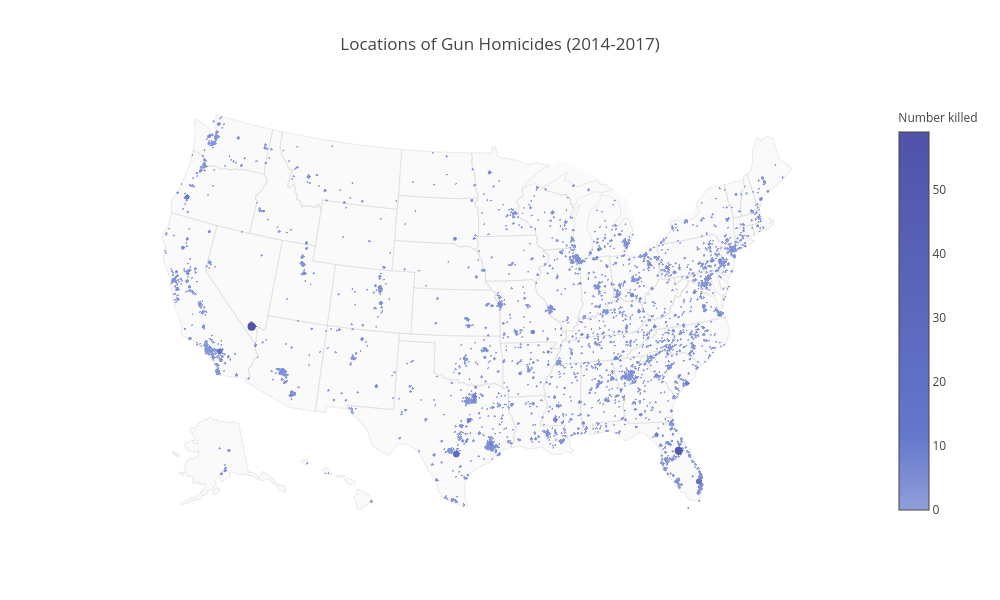

In [18]:
# Create a color scale for aesthetics
colorscale = [
            [0.0, '#909eda'],
            [0.2, '#6377cb'],
            [1.0, '#5053a8'],
            ]

# Number of points to sample (getting error from plotly server with too many points)
n_points = 50000
seed = 0

# Get the samples and sort (so large points are plotted on top)
sample_df = lat_long_df[lat_long_df['n_killed'] > 0]
sample_df = sample_df.sample(n_points, random_state=seed).sort_values('n_killed')

data = [dict(
        type = 'scattergeo',
        locationmode = 'USA-states',
        lat = sample_df['latitude'],
        lon = sample_df['longitude'],
        text = sample_df['n_killed'],
        mode = 'markers',
        marker = dict(
            size = np.log(sample_df['n_killed']) * 2,
            opacity = 1.0,
            autocolorscale = False,
            symbol = 'circle',
            line = dict(
                width = 0
            ),
            colorscale = colorscale,
            cmin = 0,
            color = sample_df['n_killed'],
            cmax = sample_df['n_killed'].max(),
            colorbar=dict(
                title="Number killed"
            )
        )
        )]

layout = dict(
        title = 'Locations of Gun Homicides (2014-2017)',
        width = 1000,
        height = 600,
        geo = dict(
            scope='usa',
            projection=dict(type='albers usa'),
            showland = True,
            landcolor = '#fafafa',
            subunitcolor = '#d9d9d9',
            countrycolor = '#d9d9d9',
            countrywidth = 1,
            subunitwidth = 0.5
        ),
    )

fig = dict( data=data, layout=layout )
# py.iplot(fig, filename='lat_long_map')
py.image.ishow(fig)